In [1]:
!pip install pandas
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357244 sha256=a76a08dc9758c97b142e62da1a0770c0064b297cbd1391b20e0e40ba0047c81c
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [2]:
import pandas as pd

# Alternative URLs for the Book-Crossing dataset
books_url = 'https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/books.csv'
ratings_url = 'https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/ratings.csv'
users_url = 'https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/tags.csv'  # No user data, using tags instead

# Load datasets
books = pd.read_csv(books_url)
ratings = pd.read_csv(ratings_url)
# users = pd.read_csv(users_url)  # Not needed for this example

# Display the first few rows of each dataset
print(books.head())
print(ratings.head())


   book_id  goodreads_book_id  best_book_id  work_id  books_count       isbn  \
0        1            2767052       2767052  2792775          272  439023483   
1        2                  3             3  4640799          491  439554934   
2        3              41865         41865  3212258          226  316015849   
3        4               2657          2657  3275794          487   61120081   
4        5               4671          4671   245494         1356  743273567   

         isbn13                      authors  original_publication_year  \
0  9.780439e+12              Suzanne Collins                     2008.0   
1  9.780440e+12  J.K. Rowling, Mary GrandPré                     1997.0   
2  9.780316e+12              Stephenie Meyer                     2005.0   
3  9.780061e+12                   Harper Lee                     1960.0   
4  9.780743e+12          F. Scott Fitzgerald                     1925.0   

                             original_title  ... ratings_count  \
0 

In [3]:
# Filter the ratings dataset to include only users who have rated at least 100 books
user_counts = ratings['user_id'].value_counts()
ratings = ratings[ratings['user_id'].isin(user_counts[user_counts >= 100].index)]


In [4]:
# Filter the ratings dataset to include only books that have been rated at least 50 times
book_counts = ratings['book_id'].value_counts()
ratings = ratings[ratings['book_id'].isin(book_counts[book_counts >= 50].index)]


In [5]:
# Merge ratings with books to get book titles
ratings = ratings.merge(books[['book_id', 'title']], on='book_id')


In [6]:
print(ratings.head())

   user_id  book_id  rating                                              title
0        1      258       5  The Shadow of the Wind (The Cemetery of Forgot...
1       11      258       3  The Shadow of the Wind (The Cemetery of Forgot...
2      143      258       4  The Shadow of the Wind (The Cemetery of Forgot...
3      242      258       5  The Shadow of the Wind (The Cemetery of Forgot...
4      325      258       4  The Shadow of the Wind (The Cemetery of Forgot...


In [10]:
from surprise.model_selection import train_test_split

# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)


In [11]:
from surprise import SVD

# Use the SVD algorithm
svd = SVD()

# Train the model
svd.fit(trainset)


In [12]:
from surprise import accuracy

# Make predictions on the test set
predictions = svd.test(testset)

# Evaluate the model's accuracy
print(f"RMSE: {accuracy.rmse(predictions)}")

RMSE: 0.8305
RMSE: 0.830517775740821


In [13]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

# Define a function to calculate precision and recall at a threshold
def precision_recall_at_k(predictions, k=5, threshold=3.5):
    # First map the predictions to each user.
    user_est_true = {}
    for uid, iid, true_r, est, _ in predictions:
        if uid not in user_est_true:
            user_est_true[uid] = []
        user_est_true[uid].append((est, true_r))

    precisions = []
    recalls = []

    # Calculate precision and recall for each user
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (est, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, true_r) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])

        # Precision@k: Proportion of recommended items that are relevant
        if n_rec_k != 0:
            precisions.append(n_rel_and_rec_k / n_rec_k)
        else:
            precisions.append(1)

        # Recall@k: Proportion of relevant items that are recommended
        if n_rel != 0:
            recalls.append(n_rel_and_rec_k / n_rel)
        else:
            recalls.append(1)

    return np.mean(precisions), np.mean(recalls)

# Calculate precision and recall at k
precision, recall = precision_recall_at_k(predictions, k=5, threshold=3.5)

print(f'Precision: {precision}')
print(f'Recall: {recall}')


Precision: 0.8441839247833747
Recall: 0.26376024301796513


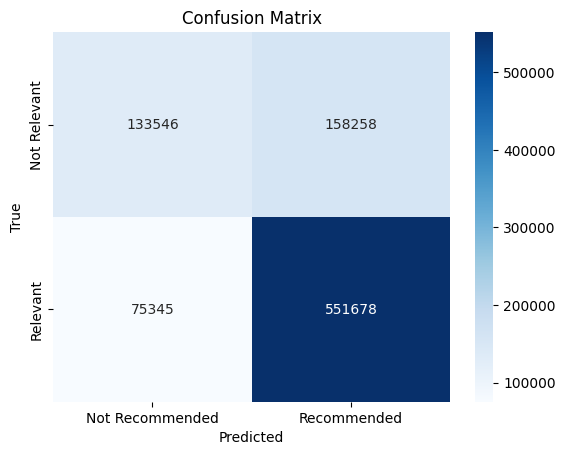

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define threshold
threshold = 3.5

# Get true labels and predicted labels based on the threshold
y_true = [true_r >= threshold for (_, _, true_r, _, _) in predictions]
y_pred = [est >= threshold for (_, _, _, est, _) in predictions]

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Recommended', 'Recommended'], yticklabels=['Not Relevant', 'Relevant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [15]:
def get_recommendations(user_id, num_recommendations=10):
    # Get all book ids
    book_ids = ratings['book_id'].unique()
    # Predict ratings for all books
    predictions = [svd.predict(user_id, book_id) for book_id in book_ids]
    # Sort by predicted rating
    predictions = sorted(predictions, key=lambda x: x.est, reverse=True)
    # Get top N recommendations
    top_predictions = predictions[:num_recommendations]

    # Get the book titles for the top recommendations
    top_book_ids = [pred.iid for pred in top_predictions]
    top_books = books[books['book_id'].isin(top_book_ids)][['book_id', 'title']]

    return top_books

# Example: Get recommendations for a specific user
user_id = 325  # Replace with a valid user ID from your dataset
recommendations = get_recommendations(user_id)
print(recommendations)


      book_id                                              title
861       862     Words of Radiance (The Stormlight Archive, #2)
1009     1010  The Essential Calvin and Hobbes: A Calvin and ...
1379     1380                     The Complete Maus (Maus, #1-2)
2373     2374                                    Angle of Repose
3394     3395                   The Kindly Ones (The Sandman #9)
5206     5207  The Days Are Just Packed: A Calvin and Hobbes ...
6919     6920                The Indispensable Calvin and Hobbes
8977     8978                        The Revenge of the Baby-Sat
9075     9076    Preach My Gospel: A Guide To Missionary Service
9565     9566  Attack of the Deranged Mutant Killer Monster S...
